In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3

database_file = 'data/cleaned-data.db'
table_name = 'Main Table'

conn = sqlite3.connect(database_file)

tables_query = "SELECT * FROM 'Main Table';"
cleaned_df = pd.read_sql_query(tables_query, conn)

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5)
}

# Ініціалізація стратифікованого розбиття
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


columns_to_drop = [
    'charging_station_id',
    'charging_start_time',
    'charging_end_time',
    'vehicle_model',
    'charging_station_location',
    'time_of_day',
    'day_of_week',
    'charger_type_Level 1',
    'charger_type_Level 2',
    'ChargerType_Target'
]



Тренування моделі: Logistic Regression
  Fold 1...
  Fold 1 завершено. Accuracy: 0.3485
  Fold 2...
  Fold 2 завершено. Accuracy: 0.3333
  Fold 3...
  Fold 3 завершено. Accuracy: 0.3295
  Fold 4...
  Fold 4 завершено. Accuracy: 0.3977
  Fold 5...
  Fold 5 завершено. Accuracy: 0.3295


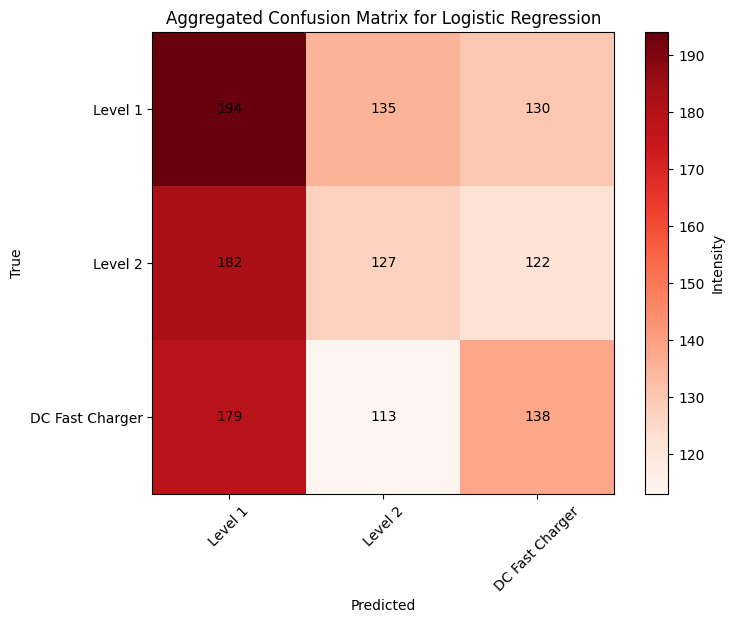


Тренування моделі: SVC
  Fold 1...
  Fold 1 завершено. Accuracy: 0.3864
  Fold 2...
  Fold 2 завершено. Accuracy: 0.3674
  Fold 3...
  Fold 3 завершено. Accuracy: 0.3636
  Fold 4...
  Fold 4 завершено. Accuracy: 0.3333
  Fold 5...
  Fold 5 завершено. Accuracy: 0.3144


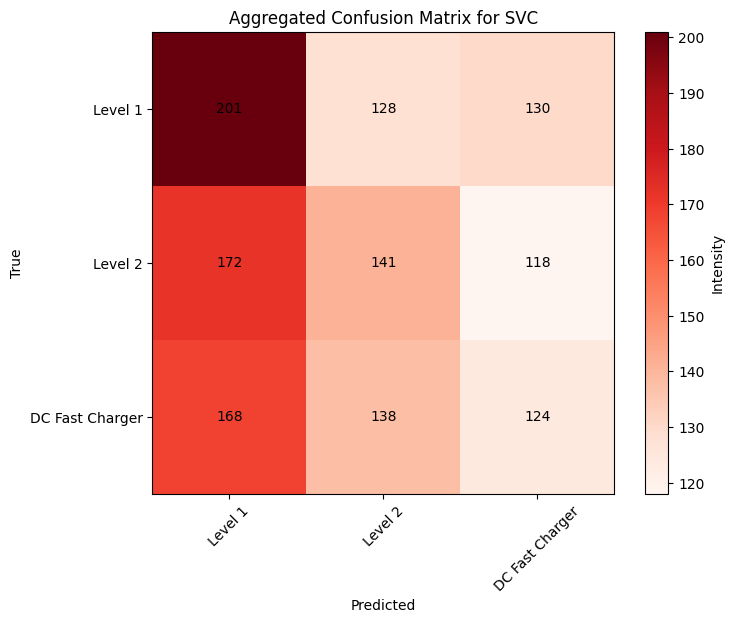


Тренування моделі: Random Forest
  Fold 1...
  Fold 1 завершено. Accuracy: 0.3674
  Fold 2...
  Fold 2 завершено. Accuracy: 0.3220
  Fold 3...
  Fold 3 завершено. Accuracy: 0.3144
  Fold 4...
  Fold 4 завершено. Accuracy: 0.3144
  Fold 5...
  Fold 5 завершено. Accuracy: 0.3561


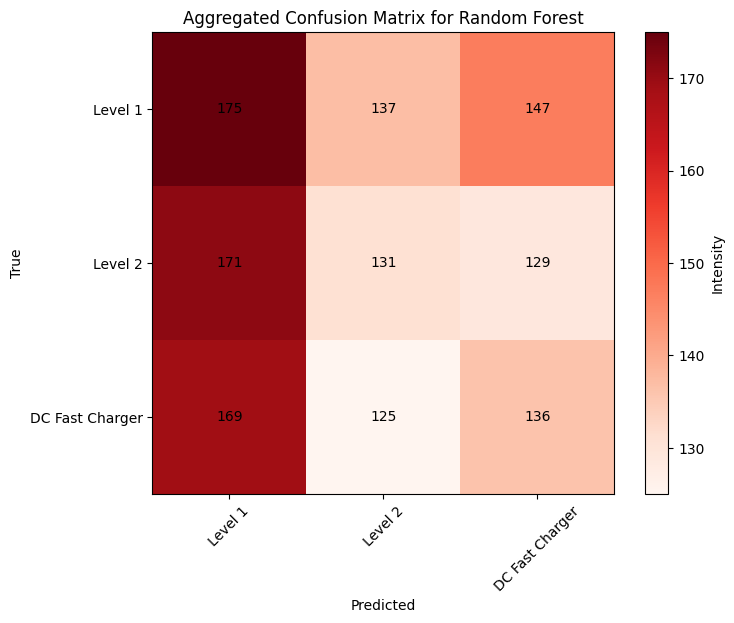


Тренування моделі: k-NN
  Fold 1...
  Fold 1 завершено. Accuracy: 0.3939
  Fold 2...
  Fold 2 завершено. Accuracy: 0.3333
  Fold 3...
  Fold 3 завершено. Accuracy: 0.3333
  Fold 4...
  Fold 4 завершено. Accuracy: 0.3144
  Fold 5...
  Fold 5 завершено. Accuracy: 0.3220


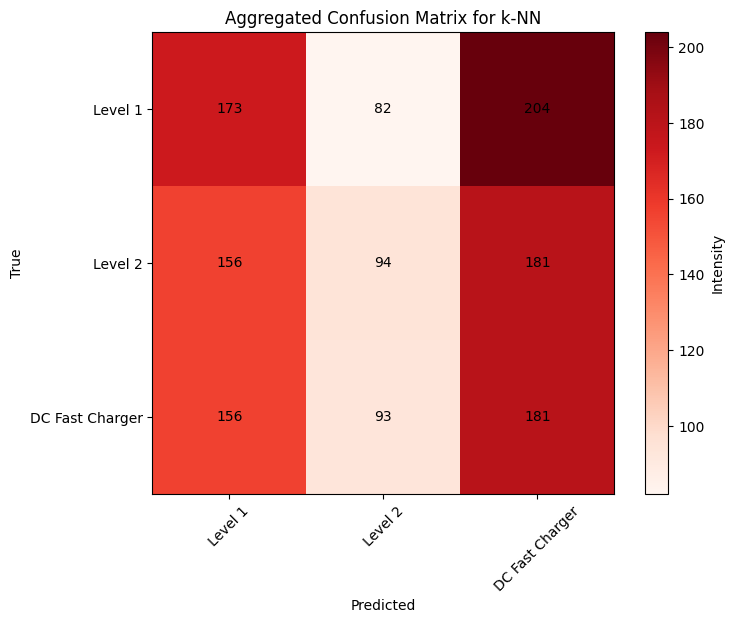

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import sqlite3
import joblib
import os
import json
import matplotlib.pyplot as plt

# --- Налаштування шляхів для збереження ---
MODELS_DIR = 'models'
LOGS_DIR = 'logs'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# --- Зчитування даних ---
database_file = 'data/cleaned-data.db'
table_name = 'Main Table'

conn = sqlite3.connect(database_file)
tables_query = "SELECT * FROM 'Main Table';"
cleaned_df = pd.read_sql_query(tables_query, conn)
conn.close()

# --- Підготовка даних ---
def prepare_data(df):
    # Створення цільової змінної
    conditions = [
        df['charger_type_Level 1'] == True,
        df['charger_type_Level 2'] == True
    ]
    choices = ['Level 1', 'Level 2']
    df['ChargerType_Target'] = np.select(conditions, choices, default='DC Fast Charger')
    
    # Вибір ознак і цільової змінної
    y_column = 'ChargerType_Target'

    columns_to_drop = [
        'charging_station_id',
        'charging_start_time',
        'charging_end_time',
        'vehicle_model',
        'charging_station_location',
        'time_of_day',
        'day_of_week',
        'charger_type_Level 1',
        'charger_type_Level 2',
        'ChargerType_Target'
    ]
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    x_columns = df.columns.drop(existing_columns_to_drop)
    
    X = df[x_columns]
    y = df[y_column]
    
    # Локальна нормалізація ознак для k-NN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, scaler

# Підготовка даних
X, y, scaler = prepare_data(cleaned_df)

# --- Ініціалізація моделей ---
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5)
}

# --- Ініціалізація StratifiedKFold ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Тренування та валідація моделей із StratifiedKFold ---
model_testing_logs = []

for name, model in models.items():
    print(f"\nТренування моделі: {name}")
    
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'confusion_matrix': []  # Для зберігання матриць плутанини по фолдах
    }
    
    # Виконання StratifiedKFold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f"  Fold {fold}...")
        
        # Розбиття на тренувальну та валідаційну вибірки
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Тренування моделі на тренувальних даних фолду
        model.fit(X_train, y_train)
        
        # Передбачення на валідаційній вибірці
        y_pred = model.predict(X_val)
        
        # Обчислення метрик для поточного фолду
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_val, y_pred, labels=['Level 1', 'Level 2', 'DC Fast Charger'])
        
        # Зберігання метрик для поточного фолду
        fold_metrics['accuracy'].append(acc)
        fold_metrics['precision'].append(prec)
        fold_metrics['recall'].append(rec)
        fold_metrics['f1_score'].append(f1)
        fold_metrics['confusion_matrix'].append(cm.tolist())
        
        print(f"  Fold {fold} завершено. Accuracy: {acc:.4f}")
    
    # Обчислення середніх метрик по всіх фолдах
    avg_metrics = {
        'accuracy': float(np.mean(fold_metrics['accuracy'])),
        'precision': float(np.mean(fold_metrics['precision'])),
        'recall': float(np.mean(fold_metrics['recall'])),
        'f1_score': float(np.mean(fold_metrics['f1_score'])),
        'confusion_matrix': [cm for cm in fold_metrics['confusion_matrix']]  # Зберігаємо всі матриці плутанини
    }
    
    # Обчислення агрегованої матриці плутанини (сумування по фолдах)
    aggregated_cm = np.sum(fold_metrics['confusion_matrix'], axis=0)
    
    # Візуалізація агрегованої Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(aggregated_cm, interpolation='nearest', cmap='Reds')
    plt.title(f'Aggregated Confusion Matrix for {name}')
    plt.colorbar(label='Intensity')
    plt.xticks(np.arange(3), ['Level 1', 'Level 2', 'DC Fast Charger'], rotation=45)
    plt.yticks(np.arange(3), ['Level 1', 'Level 2', 'DC Fast Charger'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(3):
        for j in range(3):
            plt.text(j, i, aggregated_cm[i, j], ha='center', va='center', color='black')
    plt.show()
    
    # Тренування моделі на всіх даних для остаточного збереження
    model.fit(X, y)
    model_filename = f"{name.replace(' ', '_').lower()}.joblib"
    model_path = os.path.join(MODELS_DIR, model_filename)
    joblib.dump(model, model_path)
    
    # Логування середніх метрик для моделі
    model_testing_logs.append({
        'model': name,
        'average_metrics': avg_metrics
    })
# --- Збереження логів у JSON ---
testing_log_path = os.path.join(LOGS_DIR, 'training_logs.json')
with open(testing_log_path, 'w') as f:
    json.dump(model_testing_logs, f, indent=4)


Тренування моделі: Logistic Regression
  Fold 1...
  Fold 1 завершено. Accuracy: 0.3485
  Fold 2...
  Fold 2 завершено. Accuracy: 0.3333
  Fold 3...
  Fold 3 завершено. Accuracy: 0.3295
  Fold 4...
  Fold 4 завершено. Accuracy: 0.3977
  Fold 5...
  Fold 5 завершено. Accuracy: 0.3295


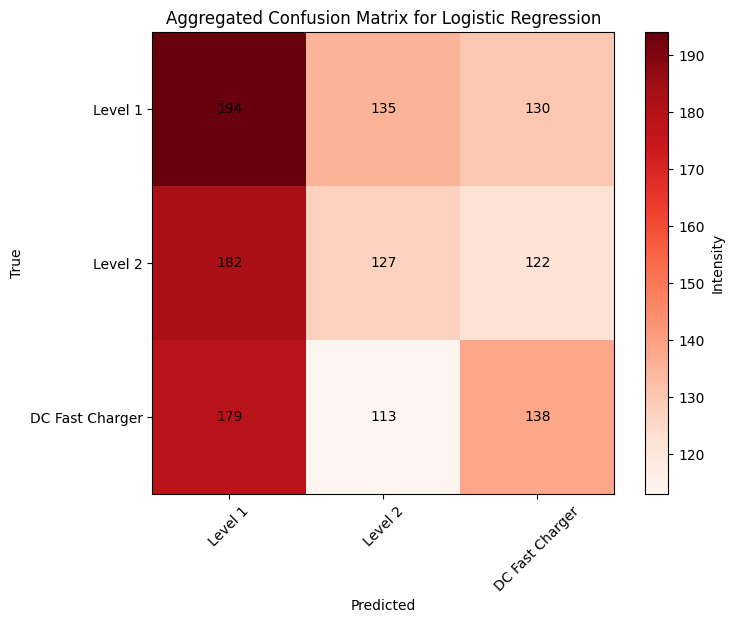


Тренування моделі: SVC
  Fold 1...
  Fold 1 завершено. Accuracy: 0.3864
  Fold 2...
  Fold 2 завершено. Accuracy: 0.3674
  Fold 3...
  Fold 3 завершено. Accuracy: 0.3636
  Fold 4...
  Fold 4 завершено. Accuracy: 0.3333
  Fold 5...
  Fold 5 завершено. Accuracy: 0.3144


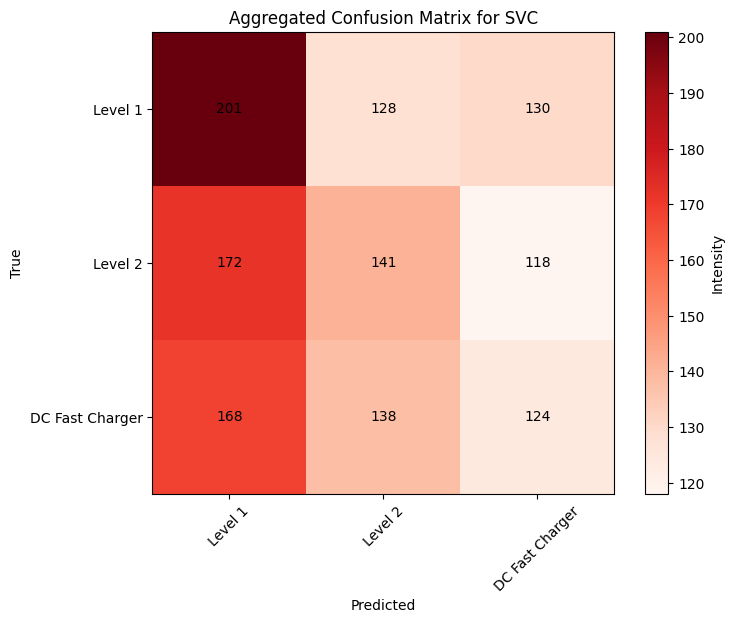


Тренування моделі: Random Forest
  Fold 1...
  Fold 1 завершено. Accuracy: 0.3674
  Fold 2...
  Fold 2 завершено. Accuracy: 0.3220
  Fold 3...
  Fold 3 завершено. Accuracy: 0.3144
  Fold 4...
  Fold 4 завершено. Accuracy: 0.3144
  Fold 5...
  Fold 5 завершено. Accuracy: 0.3561


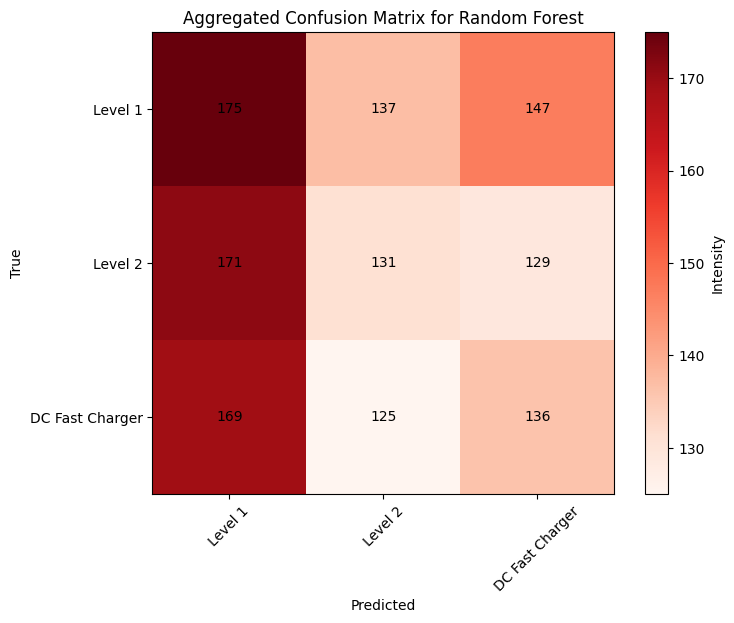


Тренування моделі: k-NN
  Fold 1...
  Fold 1 завершено. Accuracy: 0.3939
  Fold 2...
  Fold 2 завершено. Accuracy: 0.3333
  Fold 3...
  Fold 3 завершено. Accuracy: 0.3333
  Fold 4...
  Fold 4 завершено. Accuracy: 0.3144
  Fold 5...
  Fold 5 завершено. Accuracy: 0.3220


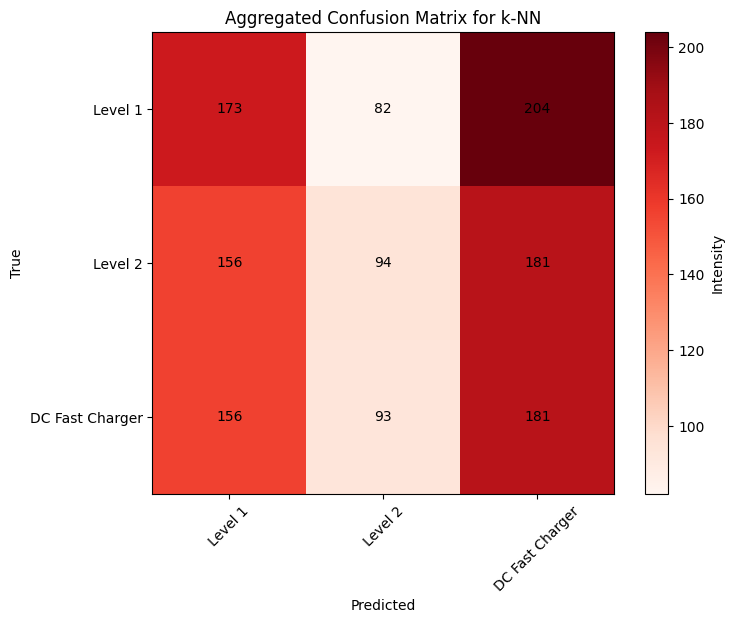

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import sqlite3
import joblib
import os
import json
import matplotlib.pyplot as plt

# --- Налаштування шляхів для збереження ---
MODELS_DIR = 'models'
LOGS_DIR = 'logs'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# --- Зчитування даних ---
database_file = 'data/cleaned-data.db'
table_name = 'Main Table'

conn = sqlite3.connect(database_file)
tables_query = "SELECT * FROM 'Main Table';"
cleaned_df = pd.read_sql_query(tables_query, conn)
conn.close()

# --- Підготовка даних ---
def prepare_data(df):
    # Створення цільової змінної
    conditions = [
        df['charger_type_Level 1'] == True,
        df['charger_type_Level 2'] == True
    ]
    choices = ['Level 1', 'Level 2']
    df['ChargerType_Target'] = np.select(conditions, choices, default='DC Fast Charger')
    
    # Вибір ознак і цільової змінної
    y_column = 'ChargerType_Target'

    columns_to_drop = [
        'charging_station_id',
        'charging_start_time',
        'charging_end_time',
        'vehicle_model',
        'charging_station_location',
        'time_of_day',
        'day_of_week',
        'charger_type_Level 1',
        'charger_type_Level 2',
        'ChargerType_Target'
    ]
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    x_columns = df.columns.drop(existing_columns_to_drop)
    
    X = df[x_columns]
    y = df[y_column]
    
    # Локальна нормалізація ознак для k-NN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, scaler

# Підготовка даних
X, y, scaler = prepare_data(cleaned_df)

# --- Ініціалізація моделей ---
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5)
}

# --- Ініціалізація StratifiedKFold ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Тренування та валідація моделей із StratifiedKFold ---
model_testing_logs = []

for name, model in models.items():
    print(f"\nТренування моделі: {name}")
    
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'confusion_matrix': []  # Для зберігання матриць плутанини по фолдах
    }
    
    # Виконання StratifiedKFold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f"  Fold {fold}...")
        
        # Розбиття на тренувальну та валідаційну вибірки
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Тренування моделі на тренувальних даних фолду
        model.fit(X_train, y_train)
        
        # Передбачення на валідаційній вибірці
        y_pred = model.predict(X_val)
        
        # Обчислення метрик для поточного фолду
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_val, y_pred, labels=['Level 1', 'Level 2', 'DC Fast Charger'])
        
        # Зберігання метрик для поточного фолду
        fold_metrics['accuracy'].append(acc)
        fold_metrics['precision'].append(prec)
        fold_metrics['recall'].append(rec)
        fold_metrics['f1_score'].append(f1)
        fold_metrics['confusion_matrix'].append(cm.tolist())
        
        print(f"  Fold {fold} завершено. Accuracy: {acc:.4f}")
    
    # Обчислення середніх метрик по всіх фолдах
    avg_metrics = {
        'accuracy': float(np.mean(fold_metrics['accuracy'])),
        'precision': float(np.mean(fold_metrics['precision'])),
        'recall': float(np.mean(fold_metrics['recall'])),
        'f1_score': float(np.mean(fold_metrics['f1_score'])),
        'confusion_matrix': [cm for cm in fold_metrics['confusion_matrix']]  # Зберігаємо всі матриці плутанини
    }
    
    # Обчислення агрегованої матриці плутанини (сумування по фолдах)
    aggregated_cm = np.sum(fold_metrics['confusion_matrix'], axis=0)
    
    # Візуалізація агрегованої Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(aggregated_cm, interpolation='nearest', cmap='Reds')
    plt.title(f'Aggregated Confusion Matrix for {name}')
    plt.colorbar(label='Intensity')
    plt.xticks(np.arange(3), ['Level 1', 'Level 2', 'DC Fast Charger'], rotation=45)
    plt.yticks(np.arange(3), ['Level 1', 'Level 2', 'DC Fast Charger'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(3):
        for j in range(3):
            plt.text(j, i, aggregated_cm[i, j], ha='center', va='center', color='black')
    plt.show()
    
    # Тренування моделі на всіх даних для остаточного збереження
    model.fit(X, y)
    model_filename = f"{name.replace(' ', '_').lower()}.joblib"
    model_path = os.path.join(MODELS_DIR, model_filename)
    joblib.dump(model, model_path)
    
    # Логування середніх метрик для моделі
    model_testing_logs.append({
        'model': name,
        'average_metrics': avg_metrics
    })

# --- Збереження логів у JSON ---
testing_log_path = os.path.join(LOGS_DIR, 'testing_logs.json')
with open(testing_log_path, 'w') as f:
    json.dump(model_testing_logs, f, indent=4)


Fold 1...
Fold 1 Accuracy: 0.3598

Fold 2...
Fold 2 Accuracy: 0.3485

Fold 3...
Fold 3 Accuracy: 0.3106

Fold 4...
Fold 4 Accuracy: 0.3636

Fold 5...
Fold 5 Accuracy: 0.3598

Mean Accuracy across folds: 0.3485

Відсортована таблиця важливості ознак:
                                 Feature  Importance
3                    energy_consumed_kwh    0.424147
4                      charging_cost_usd    0.314855
2                       charging_rate_kw    0.296876
1                    charging_duration_h    0.280434
10                    user_type_Commuter    0.259526
6   distance_driven_since_last_charge_km    0.190431
0                   battery_capacity_kwh    0.171981
8                  state_of_charge_start    0.120109
9                    state_of_charge_end    0.108987
7                          temperature_c    0.079677
11      user_type_Long-Distance Traveler    0.071119
5                      vehicle_age_years    0.059513


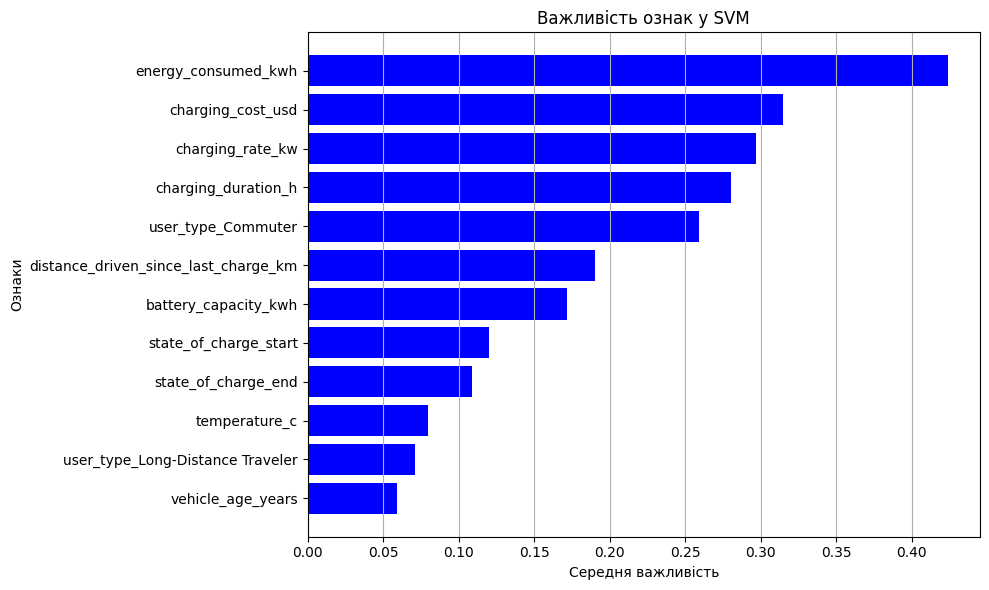


Модель збережена за шляхом: models\svm_model.joblib


In [25]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import sqlite3
import joblib
import os
import json
import matplotlib.pyplot as plt

# --- Налаштування шляхів для збереження ---
MODELS_DIR = 'models'
LOGS_DIR = 'logs'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# --- Зчитування даних ---
database_file = 'data/cleaned-data.db'
table_name = 'Main Table'

conn = sqlite3.connect(database_file)
tables_query = "SELECT * FROM 'Main Table';"
cleaned_df = pd.read_sql_query(tables_query, conn)
conn.close()

# --- Підготовка даних ---
def prepare_data(df):
    # Створення цільової змінної
    conditions = [
        df['charger_type_Level 1'] == True,
        df['charger_type_Level 2'] == True
    ]
    choices = ['Level 1', 'Level 2']
    df['ChargerType_Target'] = np.select(conditions, choices, default='DC Fast Charger')
    
    # Вибір ознак і цільової змінної
    y_column = 'ChargerType_Target'
    columns_to_drop = [
        'charging_station_id',
        'charging_start_time',
        'charging_end_time',
        'vehicle_model',
        'charging_station_location',
        'time_of_day',
        'day_of_week',
        'charger_type_Level 1',
        'charger_type_Level 2',
        'ChargerType_Target'
    ]
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    x_columns = df.columns.drop(existing_columns_to_drop)
    
    X = df[x_columns]
    y = df[y_column]
    
    # Збереження назв ознак
    feature_names = x_columns.tolist()
    
    # Нормалізація даних
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, feature_names, scaler

# Підготовка даних
X, y, feature_names, scaler = prepare_data(cleaned_df)

# --- Ініціалізація моделі SVM ---
svm_model = SVC(kernel='linear', random_state=42)  # Використано лінійне ядро для аналізу коефіцієнтів

# --- Ініціалізація StratifiedKFold ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Тренування та валідація моделі SVM із StratifiedKFold ---
fold_accuracies = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold}...")
    
    # Розбиття на тренувальну та валідаційну вибірки
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Тренування моделі
    svm_model.fit(X_train, y_train)
    
    # Передбачення та оцінка
    y_pred = svm_model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

# Обчислення середньої точності
mean_accuracy = np.mean(fold_accuracies)
print(f"\nMean Accuracy across folds: {mean_accuracy:.4f}")

# Тренування моделі на всіх даних для остаточного збереження
svm_model.fit(X, y)

# Аналіз важливості ознак
feature_importance = np.abs(svm_model.coef_)  # Абсолютні значення коефіцієнтів для мультикласової задачі
n_classes = len(np.unique(y))
mean_importance = np.mean(feature_importance, axis=0)  # Середнє значення важливості по класах

# Створення таблиці важливості ознак
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importance
})

# Сортування таблиці за спаданням важливості для кращої інтерпретації
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)
print("\nВідсортована таблиця важливості ознак:")
print(importance_df_sorted)

# Візуалізація важливості ознак (горизонтальна стовпчикова діаграма з відсортуванням)
sorted_indices = np.argsort(mean_importance)[::]
plt.figure(figsize=(10, 6))
plt.barh(range(len(mean_importance)), mean_importance[sorted_indices], color='b')
plt.yticks(range(len(mean_importance)), np.array(feature_names)[sorted_indices], rotation=0)
plt.xlabel('Середня важливість')
plt.ylabel('Ознаки')
plt.title('Важливість ознак у SVM')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# Збереження моделі та нормалізатора
model_filename = 'svm_model.joblib'
model_path = os.path.join(MODELS_DIR, model_filename)
joblib.dump(svm_model, model_path)

print(f"\nМодель збережена за шляхом: {model_path}")

C:\Users\ViktorLuka\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


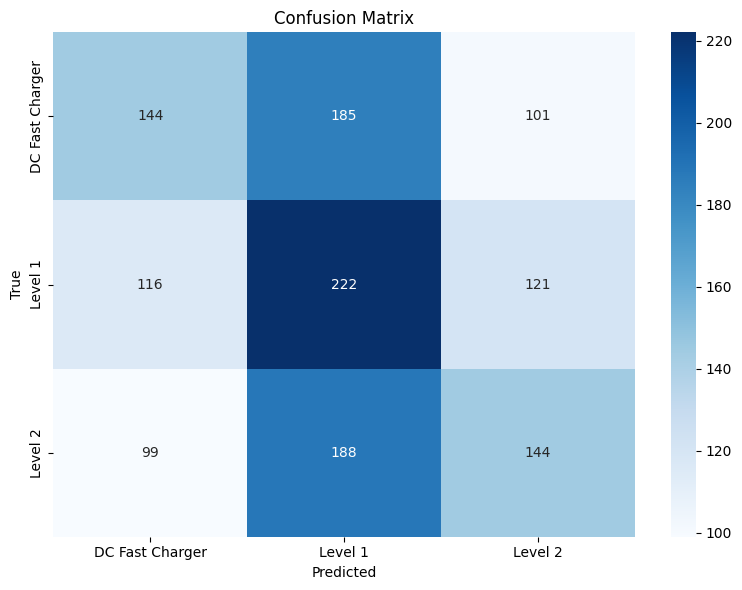

['models\\svm_model_optimized.joblib']

In [27]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import sqlite3
import joblib
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# --- Налаштування шляхів для збереження ---
MODELS_DIR = 'models'
LOGS_DIR = 'logs'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# --- Налаштування логування ---
logging.basicConfig(
    filename=os.path.join(LOGS_DIR, 'optimization_logs.log'),
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger()

# --- Функція для візуалізації confusion matrix ---
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# --- Зчитування даних ---
database_file = 'data/cleaned-data.db'
conn = sqlite3.connect(database_file)
cleaned_df = pd.read_sql_query("SELECT * FROM 'Main Table';", conn)
conn.close()

# --- Підготовка даних ---
def prepare_data(df):
    conditions = [df['charger_type_Level 1'] == True, df['charger_type_Level 2'] == True]
    choices = ['Level 1', 'Level 2']
    df['ChargerType_Target'] = np.select(conditions, choices, default='DC Fast Charger')
    
    y_column = 'ChargerType_Target'
    columns_to_drop = ['charging_station_id', 'charging_start_time', 'charging_end_time',
                       'vehicle_model', 'charging_station_location', 'time_of_day',
                       'day_of_week', 'charger_type_Level 1', 'charger_type_Level 2',
                       'ChargerType_Target']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    x_columns = df.columns.drop(existing_columns_to_drop)
    
    X = df[x_columns]
    y = df[y_column]
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, scaler

X, y, scaler = prepare_data(cleaned_df)

# --- Визначення гіперпараметрів для RandomizedSearchCV ---
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3, 4]
}

# --- Ініціалізація моделі та оптимізації ---
svm_model = SVC(random_state=42)
f1_scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring=f1_scorer,
    random_state=42,
    n_jobs=-1
)

# --- Виконання оптимізації ---
random_search.fit(X, y)

# --- Виведення та логування результатів ---
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_f1 = random_search.best_score_

# Передбачення для обчислення додаткових метрик
y_pred = best_model.predict(X)

# Обчислення метрик
f1 = f1_score(y, y_pred, average='weighted')
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

# Отримання унікальних класів для міток
classes = np.unique(y)

# Логування
logger.info(f"Найкращі гіперпараметри: {best_params}")
logger.info(f"F1-score: {best_f1:.4f}")
logger.info(f"Precision: {precision:.4f}")
logger.info(f"Recall: {recall:.4f}")
logger.info(f"Accuracy: {accuracy:.4f}")
logger.info(f"Confusion Matrix:\n{conf_matrix}")

# Візуалізація confusion matrix
plot_confusion_matrix(y, y_pred, classes)

# --- Збереження моделі ---
model_filename = 'svm_model_optimized.joblib'
model_path = os.path.join(MODELS_DIR, model_filename)
joblib.dump(best_model, model_path)